In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
data = pd.io.stata.read_stata("data_candidates_mainsample.dta")
data.to_csv('data_candidates_mainsample.csv')

data2 = pd.io.stata.read_stata("data_candidates_sample_tab6.dta")
data2.to_csv('data_\candidates_sample_tab6.csv')

data3 = pd.io.stata.read_stata("data_candidates_sample_tab7_tabA9.dta")
data3.to_csv('data_candidates_sample_tab7_tabA9.csv')

dataRe = pd.io.stata.read_stata("data_recruiters.dta")
dataRe.to_csv('data_recruiters.csv')

data_stata = pd.io.stata.StataReader("data_candidates_mainsample.dta")
data_labels = data_stata.variable_labels()

In [29]:
X_ano = pd.DataFrame()
X_unano = pd.DataFrame()

for index, row in data.iterrows():
    if row['CVA'] == 1: 
        X_ano = X_ano.append(row)
    else:
        X_unano = X_unano.append(row)

# Assign the interviewed column to our target vector
y_ano = X_ano['ENTRETIEN']
y_unano = X_unano['ENTRETIEN']

# Drop the Interviewed/hired columns (hired is much dependend on the number of jobs available
# and will currently not be considered as target label)
X_ano = X_ano.drop('RECRUTE', axis='columns')
X_unano = X_unano.drop('RECRUTE', axis='columns')

In [64]:
X_ano

,ALE_1,ALE_10,ALE_11,ALE_12,ALE_13,ALE_14,ALE_15,ALE_16,ALE_2,ALE_3,...,profint_c,recherche_LD,recherche_LD_c,recherche_TLD,recherche_TLD_c,service_m,service_m_c,service_nm,service_nm_c,travail_etranger
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,-0.246902,0.0,-0.30711,0.0,-0.115869,1.0,0.470476,0.0,-0.25469,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,-0.246902,1.0,0.69289,1.0,0.884131,1.0,0.470476,0.0,-0.25469,NaN
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,-0.246902,0.0,-0.30711,0.0,-0.115869,1.0,0.470476,0.0,-0.25469,NaN
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,-0.246902,0.0,-0.30711,0.0,-0.115869,1.0,0.470476,0.0,-0.25469,NaN
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,-0.246902,0.0,-0.30711,0.0,-0.115869,1.0,0.470476,0.0,-0.25469,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,...,-0.246902,0.0,-0.30711,0.0,-0.115869,1.0,0.470476,0.0,-0.25469,0.0
1260,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,...,-0.246902,0.0,-0.30711,0.0,-0.115869,1.0,0.470476,0.0,-0.25469,0.0
1265,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,...,-0.246902,1.0,0.69289,0.0,-0.115869,1.0,0.470476,0.0,-0.25469,1.0
1266,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,...,-0.246902,0.0,-0.30711,0.0,-0.115869,1.0,0.470476,0.0,-0.25469,0.0


# Summary Bias


# DATA1


In [32]:
data = X_ano.fillna(0)
data[47:58]

,ALE_1,ALE_10,ALE_11,ALE_12,ALE_13,ALE_14,ALE_15,ALE_16,ALE_2,ALE_3,...,profint_c,recherche_LD,recherche_LD_c,recherche_TLD,recherche_TLD_c,service_m,service_m_c,service_nm,service_nm_c,travail_etranger
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.246902,0.0,-0.30711,0.0,-0.115869,0.0,-0.529524,1.0,0.74531,0.0
104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.246902,0.0,-0.30711,0.0,-0.115869,0.0,-0.529524,1.0,0.74531,0.0
109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.246902,1.0,0.69289,0.0,-0.115869,0.0,-0.529524,1.0,0.74531,0.0
110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.246902,1.0,0.69289,0.0,-0.115869,0.0,-0.529524,1.0,0.74531,0.0
111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.246902,0.0,-0.30711,0.0,-0.115869,0.0,-0.529524,1.0,0.74531,1.0
112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.246902,0.0,-0.30711,0.0,-0.115869,0.0,-0.529524,1.0,0.74531,1.0
113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.246902,1.0,0.69289,1.0,0.884131,0.0,-0.529524,1.0,0.74531,0.0
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.246902,0.0,-0.30711,0.0,-0.115869,1.0,0.470476,0.0,-0.25469,1.0
115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.246902,0.0,-0.30711,0.0,-0.115869,1.0,0.470476,0.0,-0.25469,1.0
116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.246902,0.0,-0.30711,0.0,-0.115869,1.0,0.470476,0.0,-0.25469,0.0


-0.010624995762647603

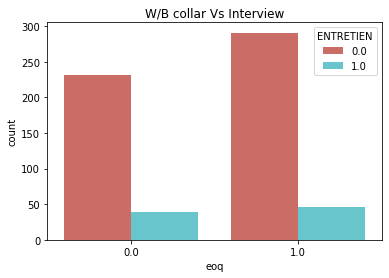

In [56]:
#skilled while/blue collar
sns.countplot(x='eoq', hue = 'ENTRETIEN', data=data, palette='hls').set_title('W/B collar Vs Interview')
data['eoq'].corr(data['ENTRETIEN'])

In [55]:
data['dip_bepcap'].corr(data['ENTRETIEN'])

0.05310087912576692

In [57]:
data['dip_bac'].corr(data['ENTRETIEN'])

0.014581832130587656

In [58]:
data['dip_bac2p'].corr(data['ENTRETIEN'])

-0.054277300711407815

In [59]:
data['dip_bac2'].corr(data['ENTRETIEN'])

-0.0341416611611043

Text(0.5, 0.98, '3yr after school Vs Interview')

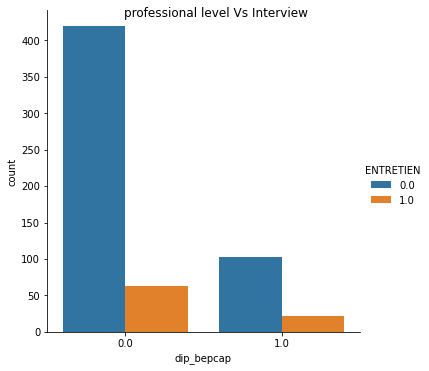

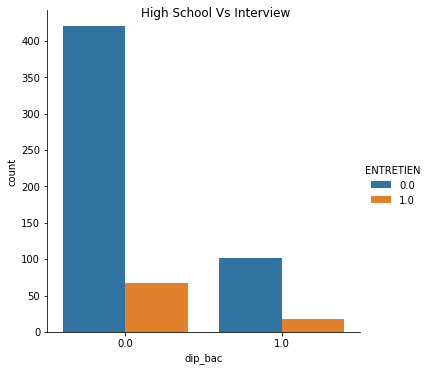

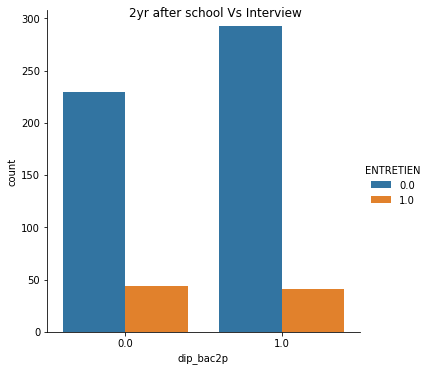

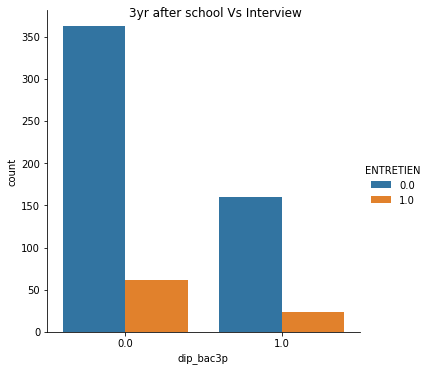

In [53]:
#professions
#data1['dip_bepcap'] professional
#data1['dip_bac'] high school
#data1['dip_bac2p'] upper education
#data1['dip_bac2']diploma 2 years after school
#data1['dip_bac3p'] diploma 3 years after school


sns.catplot(x = "dip_bepcap",hue = 'ENTRETIEN', kind = "count", data = data).fig.suptitle('professional level Vs Interview')
sns.catplot(x = "dip_bac", hue = 'ENTRETIEN', kind = "count", data = data).fig.suptitle('High School Vs Interview')
sns.catplot(x = "dip_bac2p", hue = 'ENTRETIEN',kind = "count", data = data).fig.suptitle('2yr after school Vs Interview')
sns.catplot(x = "dip_bac3p", hue = 'ENTRETIEN',kind = "count", data = data).fig.suptitle('3yr after school Vs Interview')
                                                                                                                                                                          
                                                                                         

In [36]:
x = data['FEMME']; y = data['ENTRETIEN']
x.corr(y)
y.corr(x)

-0.01597493871791148

Text(0.5, 0.98, 'gender Vs Interview')

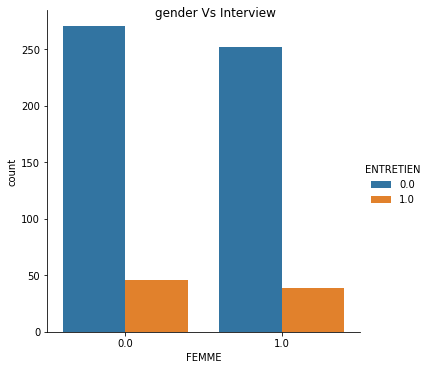

In [60]:
#gender
data['FEMME']
sns.catplot(x = "FEMME", hue = 'ENTRETIEN', kind = "count", data = data).fig.suptitle('gender Vs Interview')

Text(0.5, 0.98, 'below 26 yrs')

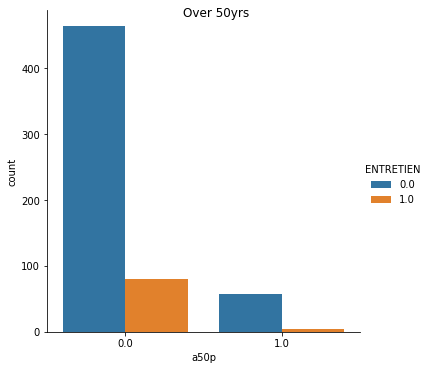

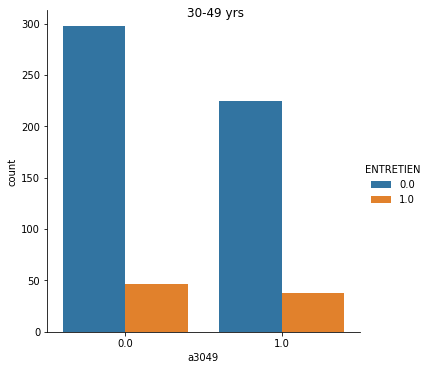

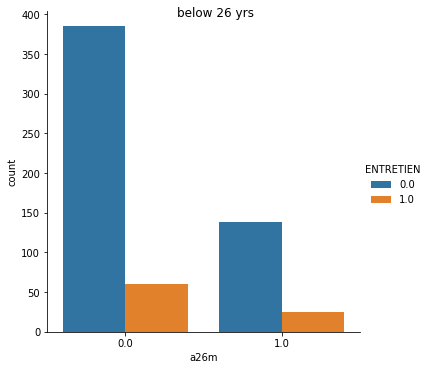

In [61]:
#age

sns.catplot(x = "a50p", hue = 'ENTRETIEN', kind = "count", data = data).fig.suptitle('Over 50yrs')
sns.catplot(x = "a3049", hue = 'ENTRETIEN', kind = "count", data = data).fig.suptitle('30-49 yrs')
sns.catplot(x = "a26m", hue = 'ENTRETIEN', kind = "count", data = data).fig.suptitle('below 26 yrs')


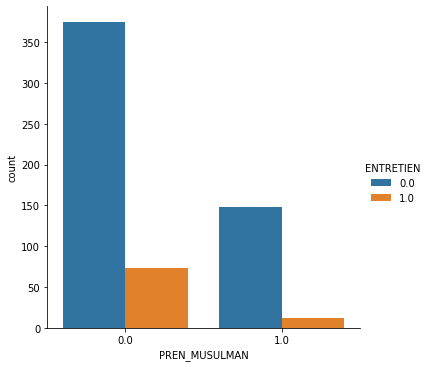

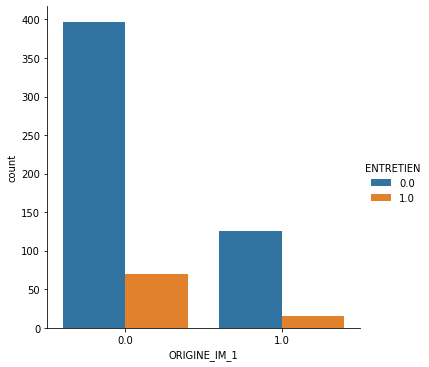

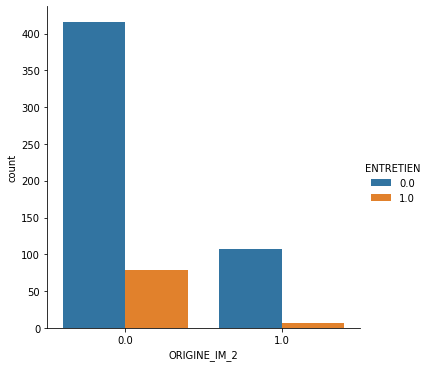

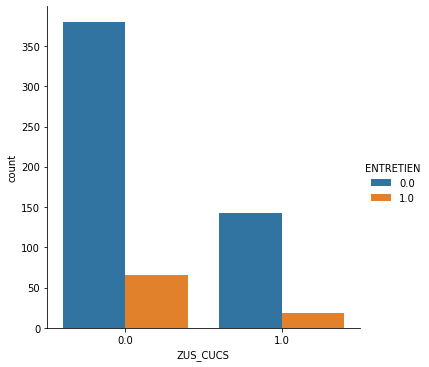

In [42]:
#race
data['PREN_MUSULMAN'] #muslim sound name
data['ORIGINE_IM_1'] #immigrant
data['ORIGINE_IM_2']#immigrant child
data['ORIGINE_IM_12'] #immigrant or immigrant child
data['ZUS_CUCS'] #Depried neighbour

sns.catplot(x = "PREN_MUSULMAN", hue = 'ENTRETIEN', kind = "count", data = data)
sns.catplot(x = "ORIGINE_IM_1", hue = 'ENTRETIEN', kind = "count", data = data)
sns.catplot(x = "ORIGINE_IM_2", hue = 'ENTRETIEN', kind = "count", data = data)
sns.catplot(x = "ZUS_CUCS", hue = 'ENTRETIEN', kind = "count", data = data)


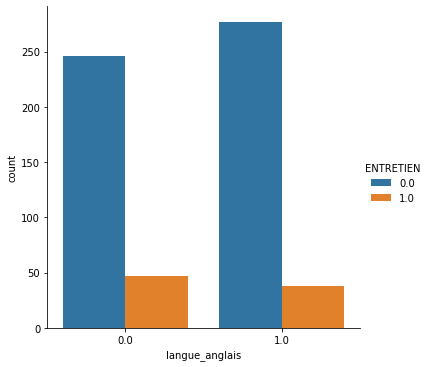

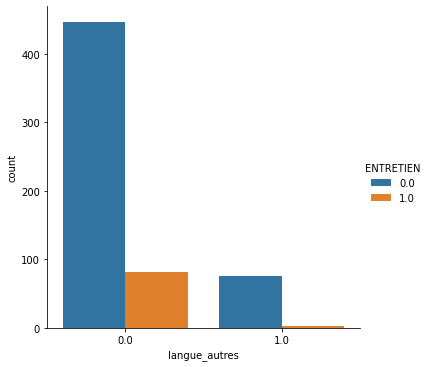

In [43]:
#language
data['langue_anglais']
data['langue_arabe']
data['langue_autres']

sns.catplot(x = "langue_anglais", hue = 'ENTRETIEN', kind = "count", data = data)
sns.catplot(x = "langue_autres", hue = 'ENTRETIEN', kind = "count", data = data)

0.05527235737433459

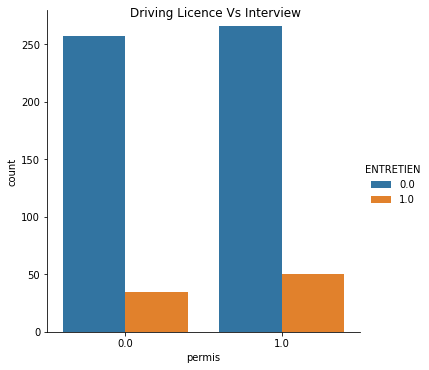

In [63]:
data['permis'] #driving license
sns.catplot(x = "permis", hue = 'ENTRETIEN', kind = "count", data = data).fig.suptitle('Driving Licence Vs Interview')
data['permis'].corr(data['ENTRETIEN'])